<a href="https://colab.research.google.com/github/Rogerio-mack/IMT_CD_2025/blob/main/IMT_Chapter3_Significance_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Testes de Significância - Exemplos**

In [ ]:
%matplotlib inline

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power, weightstats

import matplotlib.pylab as plt
import seaborn as sns

path = "https://github.com/Rogerio-mack/IMT_CD_2025/raw/refs/heads/main/data/"

# Test A/B

In [ ]:
session_times = pd.read_csv(path + 'web_page_data.csv')
session_times.Time = 100 * session_times.Time

# session_times.loc[session_times.Page == 'Page A', 'Time'] = 2*session_times.loc[session_times.Page == 'Page A', 'Time'] # Experimente 2x
# session_times.loc[session_times.Page == 'Page A', 'Time'] = 3*session_times.loc[session_times.Page == 'Page A', 'Time'] # Experimente 3x

display(session_times.head())
print(session_times.Page.value_counts())
session_times[session_times.Page == 'Page A'].Time.mean(), session_times[session_times.Page == 'Page B'].Time.mean()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


Page
Page A    21
Page B    15
Name: count, dtype: int64


(np.float64(126.33333333333333), np.float64(162.0))

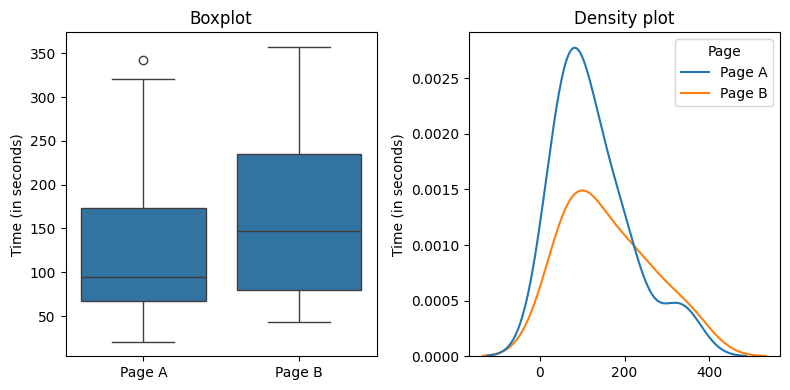

In [ ]:
fig, [ax1,ax2] = plt.subplots(1, 2, figsize=(8, 4))

ax1 = sns.boxplot(x='Page', y='Time', data=session_times, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Time (in seconds)')
ax1.set_title('Boxplot')

ax2 = sns.kdeplot(x='Time', data=session_times, hue='Page', ax=ax2)
ax2.set_xlabel('')
ax2.set_ylabel('Time (in seconds)')
ax2.set_title('Density plot')

plt.tight_layout()
plt.show()

In [ ]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


# Permutation Test

In [ ]:
# Permutation test
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

35.09523809523809


In [ ]:
n = nA + nB
idx_B = set(random.sample(range(n), nB))
idx_A = set(range(n)) - idx_B

display(session_times.loc[list(idx_B)].head())
display(session_times.loc[list(idx_A)].head())

,Page,Time
2,Page A,35.0
3,Page B,71.0
5,Page B,85.0
6,Page A,211.0
9,Page B,149.0


,Page,Time
0,Page A,21.0
1,Page B,253.0
4,Page A,67.0
7,Page B,246.0
8,Page A,132.0


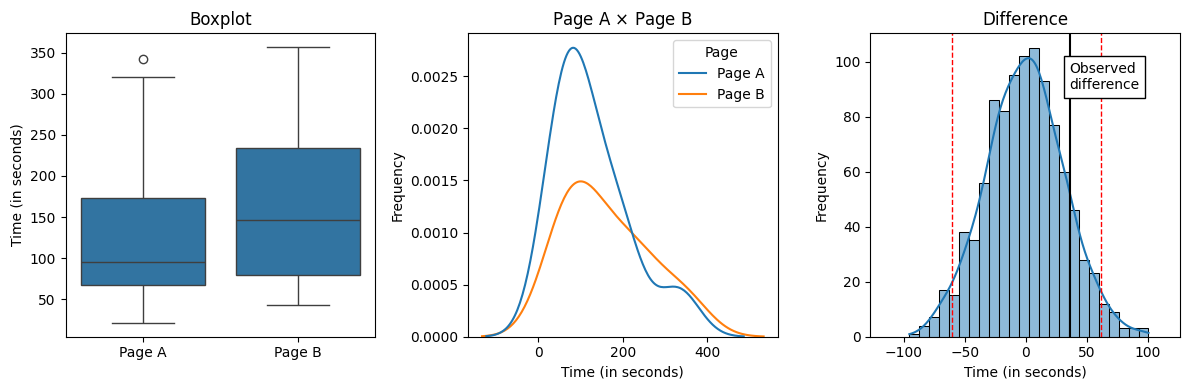

In [ ]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, [ax1,ax2,ax3] = plt.subplots(1, 3, figsize=(12, 4))

ax1 = sns.boxplot(x='Page', y='Time', data=session_times, ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('Time (in seconds)')
ax1.set_title('Boxplot')

ax2 = sns.kdeplot(x='Time', data=session_times, hue='Page', ax=ax2)
ax2.set_xlabel('Time (in seconds)')
ax2.set_ylabel('Frequency')
ax2.set_title('Page A $\\times$ Page B')

ax3 = sns.histplot(x=perm_diffs, kde=True, ax=ax3, alpha=0.5)
ax3.set_xlabel('Time (in seconds)')
ax3.set_ylabel('Frequency')
ax3.set_title('Difference')
ax3.set_xlim(np.mean(perm_diffs) - 4*np.std(perm_diffs),np.mean(perm_diffs) + 4*np.std(perm_diffs))

ax3.axvline(x = mean_b - mean_a, color='black', lw=1.5)
ax3.text(mean_b - mean_a, 90, 'Observed\ndifference', bbox={'facecolor':'white'})
ax3.axvline(x = stats.norm.ppf(0.975,loc=np.mean(perm_diffs), scale=np.std(perm_diffs)), color='red', lw=1, linestyle='--')
ax3.axvline(x = 1 - stats.norm.ppf(0.975,loc=np.mean(perm_diffs), scale=np.std(perm_diffs)), color='red', lw=1, linestyle='--')

plt.tight_layout()
plt.show()

# ~ Normal

In [ ]:
print(f'Diferença Observada: {mean_b - mean_a:.2f}')
print(f'% Até a Diferença Observada: {1 - np.mean(perm_diffs > mean_b - mean_a):.2f}')
print(f'ppf: {stats.norm.ppf(1-np.mean(perm_diffs > mean_b - mean_a),loc=np.mean(perm_diffs), scale=np.std(perm_diffs)):.2f}')
print(f'cdf: {stats.norm.cdf(mean_b - mean_a,loc=np.mean(perm_diffs), scale=np.std(perm_diffs)):.2f}')

Diferença Observada: 35.67
% Até a Diferença Observada: 0.88
ppf: 36.40
cdf: 0.87


# ~ t-Student

In [ ]:
print(f'Diferença Observada: {mean_b - mean_a:.2f}')
print(f'% Até a Diferença Observada: {1 - np.mean(perm_diffs > mean_b - mean_a):.2f}')
print(f'ppf: {stats.t.ppf(1-np.mean(perm_diffs > mean_b - mean_a),df=len(perm_diffs)-1,loc=np.mean(perm_diffs), scale=np.std(perm_diffs)):.2f}')
print(f'cdf: {stats.t.cdf(mean_b - mean_a,df=len(perm_diffs)-1,loc=np.mean(perm_diffs), scale=np.std(perm_diffs)):.2f}')

Diferença Observada: 35.67
% Até a Diferença Observada: 0.88
ppf: 36.42
cdf: 0.87


# t-Test Pressupostos

* Dados contínuos
* Normalidade
* Variâncias iguais

## Teste de normalidade, `normaltest`

> $H_0:D(μ,\sigma)=\textbf{N}(μ,\sigma)$

> $H_a:D(μ,\sigma) \ne \textbf{N}(μ,\sigma)$

In [ ]:
# Prefira este, Assimetria + Curtose, amostras maiores
normal_test = stats.normaltest(perm_diffs)
print(f'\nTeste Normal Teste:')
print(f'Estatística W: {shapiro_test.statistic:.4f}')
print(f'Valor-p: {shapiro_test.pvalue:.4f}')

alpha = 0.05
if normal_test.pvalue < alpha:
  print("Rejeitamos a hipótese nula (H0: a distribuição é normal). Há evidência estatística para concluir que a distribuição não é normal.")
else:
  print("Não rejeitamos a hipótese nula (H0: a distribuição é normal). Não há evidência estatística suficiente para concluir que a distribuição não é normal.")


Teste Normal Teste:
Estatística W: 0.9990
Valor-p: 0.8900
Não rejeitamos a hipótese nula (H0: a distribuição é normal). Não há evidência estatística suficiente para concluir que a distribuição não é normal.


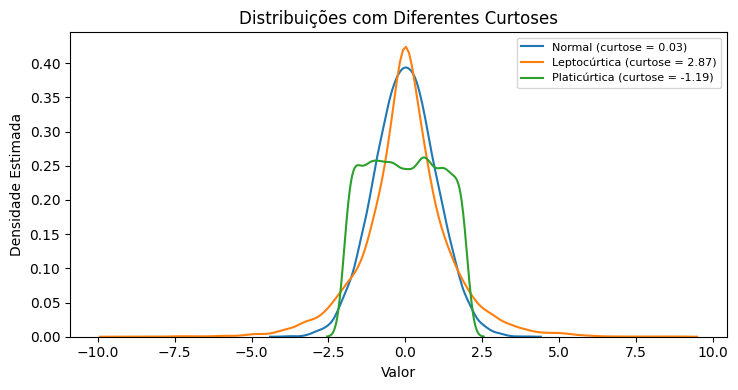

In [ ]:
#@markdown **Curtose**
from scipy.stats import kurtosis

# Gerar dados com diferentes tipos de curtose
np.random.seed(42)
data_normal = np.random.normal(0, 1, 10000)            # Curtose ~0 (distribuição normal)
data_leptokurtic = np.random.laplace(0, 1, 10000)      # Curtose >0 (caudas pesadas)
data_platokurtic = np.random.uniform(-2, 2, 10000)     # Curtose <0 (caudas leves)

# Calcular a curtose (Fisher, que subtrai 3)
k_normal = kurtosis(data_normal)
k_lepto = kurtosis(data_leptokurtic)
k_plato = kurtosis(data_platokurtic)

plt.figure(figsize=(7.5,4))
sns.kdeplot(data_normal, label=f'Normal (curtose = {k_normal:.2f})')
sns.kdeplot(data_leptokurtic, label=f'Leptocúrtica (curtose = {k_lepto:.2f})')
sns.kdeplot(data_platokurtic, label=f'Platicúrtica (curtose = {k_plato:.2f})')

plt.title("Distribuições com Diferentes Curtoses")
plt.xlabel("Valor")
plt.ylabel("Densidade Estimada")

plt.legend(fontsize=8)
plt.tight_layout()
plt.show()


In [ ]:
# Teste alternativo de Shapiro-Wilk para normalidade
shapiro_test = stats.shapiro(perm_diffs)
print(f'\nTeste de Shapiro-Wilk:')
print(f'Estatística W: {shapiro_test.statistic:.4f}')
print(f'Valor-p: {shapiro_test.pvalue:.4f}')

alpha = 0.05
if shapiro_test.pvalue < alpha:
  print("Rejeitamos a hipótese nula (H0: a distribuição é normal). Há evidência estatística para concluir que a distribuição não é normal.")
else:
  print("Não rejeitamos a hipótese nula (H0: a distribuição é normal). Não há evidência estatística suficiente para concluir que a distribuição não é normal.")


Teste de Shapiro-Wilk:
Estatística W: 0.9990
Valor-p: 0.8900
Não rejeitamos a hipótese nula (H0: a distribuição é normal). Não há evidência estatística suficiente para concluir que a distribuição não é normal.


## Levene test, `levene`

> $H_0:\sigma^2_A=\sigma^2_B$

> $H_a:\sigma^2_A \ne \sigma^2_B$

In [ ]:
# Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.

from scipy.stats import bartlett
Bstat, pvalue = bartlett(session_times[session_times.Page == 'Page A'].Time,
                         session_times[session_times.Page == 'Page B'].Time,)

print("\nBartlett Teste, (σ2A ≠ σ2B) :")
print(f'T-statistic: {tstat:.4f}')
print(f'P-value: {pvalue:.4f}')

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre as variâncias.")
else:
  print("Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença entre as variâncias.")


Bartlett Teste, (σ2A ≠ σ2B) :
T-statistic: -1.0983
P-value: 0.5901
Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença entre as variâncias.


In [ ]:
# Bartlett’s test tests the null hypothesis that all input samples are from populations with equal variances.

from scipy.stats import bartlett
Bstat, pvalue = bartlett(session_times[session_times.Page == 'Page A'].Time,
                         session_times[session_times.Page == 'Page B'].Time,)

print("\nBartlett Teste, (σ2A ≠ σ2B) :")
print(f'T-statistic: {tstat:.4f}')
print(f'P-value: {pvalue:.4f}')

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre as variâncias.")
else:
  print("Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença entre as variâncias.")


Bartlett Teste, (σ2A ≠ σ2B) :
T-statistic: -1.0983
P-value: 0.5901
Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença entre as variâncias.


# t-Test, Bilateral, `ttest_ind`

> $H_0:μ_A=μ_B$

> $H_a:μ_A \ne μ_B$

In [ ]:
tstat, pvalue = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                                 session_times[session_times.Page == 'Page B'].Time,
                                 equal_var=False) # assumindo variâncias desiguais

print("\nTeste de Hipóteses Bilateral (μ_A != μ_B):")
print(f'T-statistic: {tstat:.4f}')
print(f'P-value: {pvalue:.4f}')

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os valores médios.")
else:
  print("Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença nos valores médios.")


Teste de Hipóteses Bilateral (μ_A != μ_B):
T-statistic: -1.0983
P-value: 0.2815
Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença nos valores médios.


## z-Test, `statsmodels.weightstats.ztest`

In [ ]:
tstat, pvalue = weightstats.ztest(session_times[session_times.Page == 'Page A'].Time,
                                 session_times[session_times.Page == 'Page B'].Time,
                                 usevar='unequal') # assumindo variâncias desiguais

print("\nTeste de Hipóteses Bilateral (μ_A != μ_B):")
print(f'T-statistic: {tstat:.4f}')
print(f'P-value: {pvalue:.4f}')

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os valores médios.")
else:
  print("Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença nos valores médios.")


Teste de Hipóteses Bilateral (μ_A != μ_B):
T-statistic: -1.0983
P-value: 0.2721
Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que há uma diferença nos valores médios.


# t-Test Unilateral, `ttest_ind`

> $H_0:μ_A \geq μ_B$

> $H_a:μ_A < μ_B$



In [ ]:
tstat_one_sided, pvalue_one_sided = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time,
                                                   session_times[session_times.Page == 'Page B'].Time,
                                                   equal_var=False, # Mantendo a suposição de variâncias desiguais
                                                   alternative='less')

print("\nTeste de Hipóteses Unilateral (μ_A < μ_B):")
print(f'T-statistic: {tstat_one_sided:.4f}')
print(f'P-value: {pvalue_one_sided:.4f}')

alpha = 0.05
if pvalue_one_sided < alpha:
  print("Rejeitamos a hipótese nula (H0: μ_A >= μ_B). Há evidência estatística para concluir que o valor A é estatisticamente menor que o valor B.")
else:
  print("Não rejeitamos a hipótese nula (H0: μ_A >= μ_B). Não há evidência estatística suficiente para concluir que o valor A é estatisticamente menor que o valor B.")


Teste de Hipóteses Unilateral (μ_A < μ_B):
T-statistic: -1.0983
P-value: 0.1408
Não rejeitamos a hipótese nula (H0: μ_A >= μ_B). Não há evidência estatística suficiente para concluir que o valor A é estatisticamente menor que o valor B.


# Teste do $\chi2$ qui-quadrado

> $H_0: Independentes$

> $H_a: Dependentes$

Associação de dados categóricos. Por exemplo, há associação entre gênero e preferência por bebida?

In [ ]:
#@markdown df
df = pd.DataFrame({
    'genero': ['Homem']*40 + ['Mulher']*40,
    'bebida': ['Café']*30 + ['Chá']*10 + ['Café']*20 + ['Chá']*20
})



In [ ]:
df.iloc[np.random.choice(len(df),10)].head(10)

,genero,bebida
59,Mulher,Café
43,Mulher,Café
42,Mulher,Café
3,Homem,Café
76,Mulher,Chá
49,Mulher,Café
38,Homem,Chá
53,Mulher,Café
22,Homem,Café
59,Mulher,Café


## Tabela de Contingência

In [ ]:
tabela = pd.crosstab(df['genero'], df['bebida'])

display(tabela)

bebida,Café,Chá
genero,,
Homem,30,10
Mulher,20,20


In [ ]:
from scipy.stats import chi2_contingency

# Aplicar teste do qui-quadrado de independência
chi2, pvalue, dof, expected = chi2_contingency(tabela)

# Resultados
print("\nTeste Chi-Quadrado:")
print(f"Estatística qui-quadrado = {chi2:.2f}")
print(f"p-valor = {p:.4f}")

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há evidência estatística para concluir as variáveis são Dependentes.")
else:
  print("Não rejeitamos a hipótese nula. Não há evidência estatística suficiente para concluir que as variáveis são Dependentes.")



Teste Chi-Quadrado:
Estatística qui-quadrado = 4.32
p-valor = 0.0377
Rejeitamos a hipótese nula. Há evidência estatística para concluir as variáveis são Dependentes.


# ANOVA One-way

Compara Médias entre grupos.

> $H_0:$ todas as médias são iguais.

> $H_a:$ Dependentetodas as médias são iguais.


In [ ]:
df = pd.read_csv(path + 'four_sessions.csv')
df.columns = [c.strip() for c in df.columns]
df.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


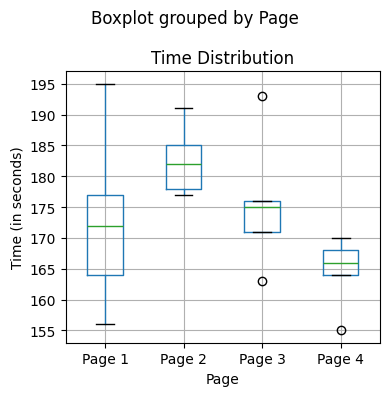

In [ ]:
ax = df.boxplot(by='Page', column='Time', figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.title('Time Distribution')

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import f_oneway

# Aplicar a ANOVA
f_stat, pvalue = f_oneway(df[df.Page == 'Page 1'].Time,
                           df[df.Page == 'Page 2'].Time,
                           df[df.Page == 'Page 3'].Time,
                           df[df.Page == 'Page 4'].Time)

# Resultados
print("\nANOVA:")
print(f"Estatística F = {f_stat:.2f}")
print(f"p-valor = {pvalue:.4f}")

alpha = 0.05
if pvalue < alpha:
  print("Rejeitamos a hipótese nula. Há evidências de que há diferença significativa entre os grupos.")
else:
  print("Não rejeitamos a hipótese nula. Nã há evidências de que há diferença significativa entre os grupos.")


ANOVA:
Estatística F = 2.74
p-valor = 0.0776
Não rejeitamos a hipótese nula. Nã há evidências de que há diferença significativa entre os grupos.


## Com `statsmodels`

In [ ]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


# t-Test $\times$ ANOVA

> **Por que fazer a ANOVA e não fazer o t-Test para cada um dos pares de variáveis?**

Suponha 3 grupos A, B e C. Você poderia fazer 3 testes t A  $\times$ B,
A  $\times$ C e B  $\times$ C, cada um com uma chance de 5% de erro (α = 0.05).  Mas com múltiplos testes, a probabilidade de pelo menos um falso positivo aumenta:

$$P_3(\text{erro em pelo menos um teste}) ≈ 1 - (0.95)^3 ≈ 14.3\%$$
$$P_4(\text{erro em pelo menos um teste}) ≈ 1 - (0.95)^6 ≈ 26.3\%$$ (6 comparações)

Logo, se você faz muitos testes t entre pares, estará enxergando diferenças onde não existem (falsos positivos).
